In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from metrics import custom_score, ultimate_score

random_seed = 42
np.random.seed(random_seed)

In [2]:
# usually (for 1 feature) there is about 7200 revenue
# for perfect prediction, we may obtain such a result using at most 14 features
MAX_FEATURES = 14
n_features = np.arange(1, MAX_FEATURES + 1)

# Loading data

In [2]:
df = pd.read_csv("data/x_train.txt", sep=" ", header=None)
print(df.shape)

y = pd.read_csv("data/y_train.txt", sep=" ", header=None)
y = np.array(y).ravel()
print(y.shape)

df_test = pd.read_csv("data/x_test.txt", sep=" ", header=None)
print(df_test.shape)

(5000, 500)
(5000,)
(5000, 500)


In [4]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# computing k to predict

# df_test.shape[0]
# we want to identify 1000 ones in 5000 dataset (there should be about 2500 ones there - balanced)

k_test = int(1000 / df_test.shape[0] * X_test.shape[0]) # equivalently, we want look for 300 ones in X_test
k_test

300

In [6]:
def forward_feature_selection(X_train, y_train, X_test, y_test, init_model, max_features=MAX_FEATURES, **kwargs):
    all_scores = []
    selected_features = []
    best_selected_features = []
    remaining_features = list(range(X_train.shape[1]))
    best_score = -np.inf
    candidate_features = []

    while len(remaining_features) > 0 and len(selected_features) < min(MAX_FEATURES, max_features):
        scores = []
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            # candidate_features = np.concatenate((selected_features, [feature])).astype(int)
            X_train_selected = X_train[:, candidate_features]
            X_test_selected = X_test[:, candidate_features]
            
            model = init_model(**kwargs)
            model.fit(X_train_selected, y_train)
            y_test_probs = model.predict_proba(X_test_selected)
            
            score = ultimate_score(y_test, y_test_probs, k_test, len(candidate_features))
            scores.append((score, feature))
        
        scores.sort(reverse=True)
        best_candidate_score, best_candidate_feature = scores[0]

        selected_features.append(best_candidate_feature)
        remaining_features.remove(best_candidate_feature)

        if best_candidate_score > best_score:
            best_score = best_candidate_score
            best_selected_features = selected_features.copy()
            print(f"Selected: {best_selected_features}, Score: {best_score:.4f}")
        else:
            print(f"No improvement, {len(candidate_features)} features, score: {best_candidate_score}")
        all_scores.append(best_candidate_score)
        
    return best_selected_features, all_scores

# Forward selection

Selected: [8], Score: 7300.0000
No improvement, 2 features, score: 7230.0
No improvement, 3 features, score: 7100.0
No improvement, 4 features, score: 6960.0
No improvement, 5 features, score: 6800.0
No improvement, 6 features, score: 6630.0
No improvement, 7 features, score: 6460.0
No improvement, 8 features, score: 6260.0
No improvement, 9 features, score: 6060.0
No improvement, 10 features, score: 5860.0
No improvement, 11 features, score: 5660.0
No improvement, 12 features, score: 5460.0
No improvement, 13 features, score: 5260.0
No improvement, 14 features, score: 5060.0
No improvement, 15 features, score: 4860.0
selected features: [8]


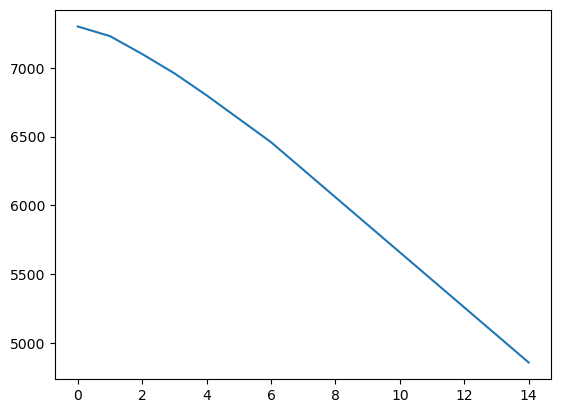

In [61]:
# LR
best_selected_features, all_scores = forward_feature_selection(X_train, y_train, X_test, y_test, LogisticRegression, random_state=random_seed)
print(f"selected features: {best_selected_features}")

plt.plot(np.arange(len(all_scores)), all_scores)
plt.show()

Selected: [8], Score: 7230.0000
Selected: [8, 246], Score: 7300.0000
No improvement, 3 features, score: 7100.0
No improvement, 4 features, score: 7000.0
No improvement, 5 features, score: 6800.0
No improvement, 6 features, score: 6630.0
No improvement, 7 features, score: 6500.0
No improvement, 8 features, score: 6300.0
No improvement, 9 features, score: 6230.0
No improvement, 10 features, score: 6060.0
No improvement, 11 features, score: 5730.0
No improvement, 12 features, score: 5530.0
No improvement, 13 features, score: 5400.0
No improvement, 14 features, score: 4960.0
No improvement, 15 features, score: 4900.0
selected features: [8, 246]


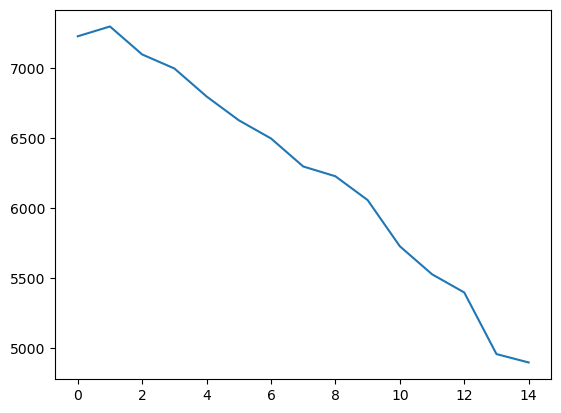

In [7]:
# RF
best_selected_features, all_scores = forward_feature_selection(X_train, y_train, X_test, y_test, RandomForestClassifier, n_estimators=100, max_depth=5, n_jobs=-1, random_state=random_seed)
print(f"selected features: {best_selected_features}")

plt.plot(np.arange(len(all_scores)), all_scores)
plt.show()

Selected: [3], Score: 7100.0000
No improvement, 2 features, score: 7030.0
No improvement, 3 features, score: 6960.0
No improvement, 4 features, score: 6800.0
No improvement, 5 features, score: 6600.0
No improvement, 6 features, score: 6630.0
No improvement, 7 features, score: 6130.0
No improvement, 8 features, score: 6030.0
No improvement, 9 features, score: 5800.0
No improvement, 10 features, score: 5630.0
No improvement, 11 features, score: 5400.0
No improvement, 12 features, score: 5460.0
No improvement, 13 features, score: 5260.0
No improvement, 14 features, score: 5130.0
No improvement, 15 features, score: 4860.0
selected features: [3]


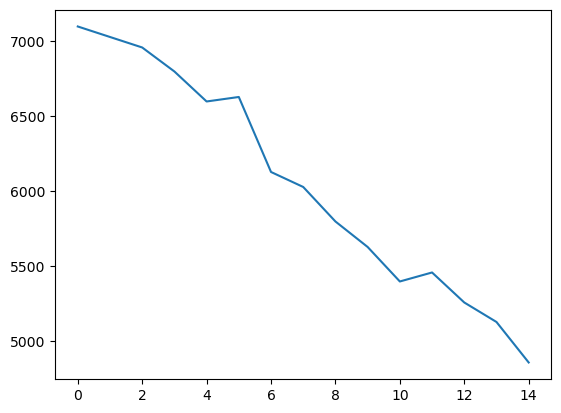

In [8]:
# XGB
best_selected_features, all_scores = forward_feature_selection(X_train, y_train, X_test, y_test, XGBClassifier, n_estimators=100, max_depth=5, n_jobs=-1, random_state=random_seed)
print(f"selected features: {best_selected_features}")

plt.plot(np.arange(len(all_scores)), all_scores)
plt.show()

Selected: [8], Score: 7300.0000
No improvement, 2 features, score: 7200.0
No improvement, 3 features, score: 7060.0
No improvement, 4 features, score: 6900.0
No improvement, 5 features, score: 6730.0
No improvement, 6 features, score: 6630.0
No improvement, 7 features, score: 6430.0
No improvement, 8 features, score: 6230.0
No improvement, 9 features, score: 6060.0
No improvement, 10 features, score: 5860.0
No improvement, 11 features, score: 5660.0
No improvement, 12 features, score: 5460.0
No improvement, 13 features, score: 5260.0
No improvement, 14 features, score: 5060.0
No improvement, 15 features, score: 4860.0
selected features: [8]


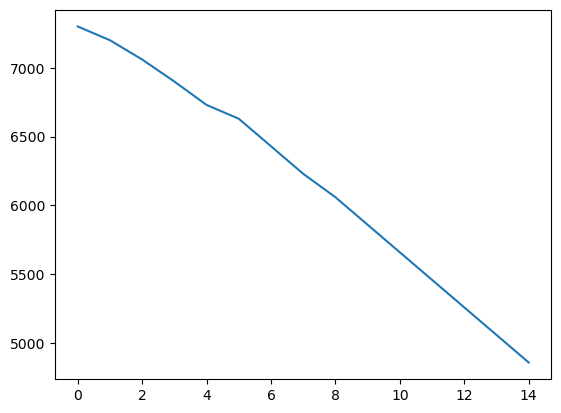

In [9]:
# SVM
best_selected_features, all_scores = forward_feature_selection(X_train, y_train, X_test, y_test, SVC, kernel='linear', probability=True, random_state=random_seed)
print(f"selected features: {best_selected_features}")

plt.plot(np.arange(len(all_scores)), all_scores)
plt.show()

# Saving results

In [13]:
# preparing data
X = df.values[:, [8, 246]]
# y
X_test = df_test.values[:, [8, 246]]
k_test = 1000

In [12]:
# training RF on full set
rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=random_seed)
rf.fit(X, y)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [17]:
# predicting ones
y_pred_probs = rf.predict_proba(X_test)
top_k_indices = np.argsort(y_pred_probs[:, 1])[::-1][:k_test]
# saving results
np.savetxt('solutions/320657_obs.txt', top_k_indices, fmt='%d')

In [18]:
top_k_indices

array([  62, 3576, 4068, 3447, 4856, 4192, 2712, 2916, 1014, 4915,  632,
       3526, 2726,   75, 2349, 4673,  394, 3793, 4873,  335,  313, 3521,
       4043, 2054, 3595, 3483, 2997, 4008, 4246, 1699, 4640,  331,  894,
       1283, 3846,  208,  101, 4539,  237, 4220, 1016,  584, 1182, 4875,
       3962, 4534, 3898,  287, 1375, 1980, 1300,  889, 3515, 2780, 2063,
       1537, 1235,   80, 1842, 3347, 1197, 3588, 3767, 2469, 4642, 1520,
       1756, 1233, 1868, 1611, 3996, 1105, 1830, 1704, 2620,  712, 1737,
       3535,  943, 3538, 4148, 2837, 3201, 2109, 3439, 4904, 4911, 4498,
       3921, 1873, 2815, 3570, 4859, 3403, 4651, 4883, 3052, 2334, 2412,
       4627, 2444, 1877, 1991, 1848,  200, 1903, 2235, 2791, 3761, 1983,
        149, 4271, 3151, 3844, 2126, 1135, 4997, 3015,  801,  566, 3762,
       4491, 1569, 3080, 1254,  512, 1493,  743,  873, 3149, 3441, 1053,
        107, 1180, 4910, 3598, 3037, 2489, 1132, 1506, 4013,  415, 4123,
       3965, 4484, 1723, 3394,  724, 2470,    2, 22